# Time Series Modeling Exercises

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from vega_datasets import data

In [3]:
stocks = data.stocks()
# Create a tidy dataframe to practice modeling time series data - Thank you Zach.
df = stocks.pivot_table('price', 'date', 'symbol')

In [4]:
# Look at the shape of our data
print(df.shape)

# Make sure the index is a datetime datatype
print(df.index.dtype)

# Check to see if there are any duplicate dates in the index
print(df.index.is_unique)

(123, 5)
datetime64[ns]
True


In [5]:
# display the first 5 rows of our dataframe
df.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45


In [6]:
# display the dtypes and # of null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    123 non-null    float64
 1   AMZN    123 non-null    float64
 2   GOOG    68 non-null     float64
 3   IBM     123 non-null    float64
 4   MSFT    123 non-null    float64
dtypes: float64(5)
memory usage: 10.8 KB


In [7]:
# fill missing values
df.GOOG = df.GOOG.fillna(0)

## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [8]:
# resample monthly data -> quarterly data
df_quarterly = df.resample('3M').agg('sum')

In [9]:
# Time series data is sequential. Each time-step is dependent upon the next.
# For example: If it's 12:00pm now, it can't be 12:30pm 1 minute later.
# There are 30, 1 minute intervals between 12:00pm and 12:30pm.

# Create index variables to explictly define the index cutoff points
# for train, validate, and test sets.

# Use the percent based method to split the data.
# Implicitly round the index number to an int
train_size = int(len(df_quarterly) * .5)
validate_size = int(len(df_quarterly) * .3)

# Use index variable names: train and validate for reproducibility
test_size = int(len(df_quarterly) - train_size - validate_size)

# Calculate the tail/last index of the validation set by adding the
# The length of the training set + length validation set
validate_cutoff_index = train_size + validate_size

# Split the data using the indexes returned from the percentage based method - index slicing
train = df_quarterly[: train_size]
validate = df_quarterly[train_size : validate_cutoff_index]
test = df_quarterly[validate_cutoff_index :]

In [10]:
df_quarterly[train_size : validate_cutoff_index]

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2005-04-30,122.59,101.81,588.50,241.21,68.67
2005-07-31,119.22,113.75,859.18,216.64,70.39
2005-10-31,158.09,127.86,974.60,226.02,72.98
2006-01-31,215.22,140.43,1252.43,235.60,76.14
2006-04-30,201.60,109.18,1170.56,229.31,72.90
2006-07-31,185.00,100.18,1177.75,219.89,65.50
2006-10-31,225.91,101.04,1256.82,240.67,76.77
2007-01-31,262.23,117.47,1446.79,272.64,84.86
2007-04-30,277.32,140.26,1378.99,274.60,81.28


In [11]:
# To ensure the splits were correct lets compare the length of each
# modeling set with the length of the resampled dataframe.
print(len(train + validate + test) == len(df_quarterly))

True


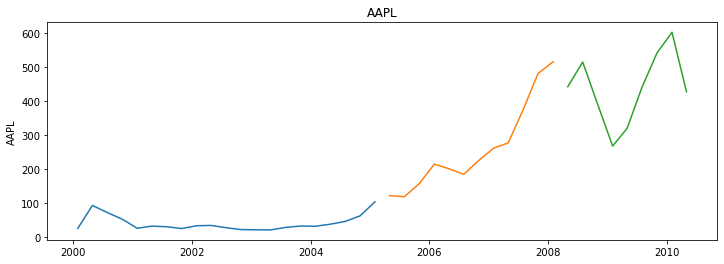

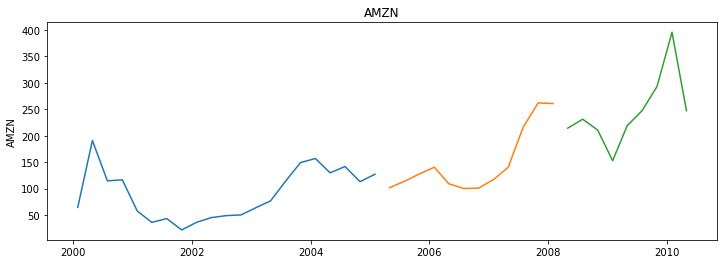

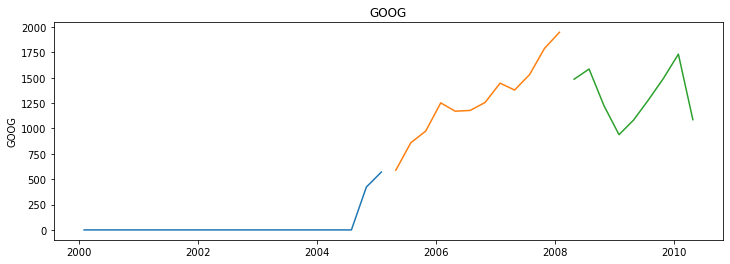

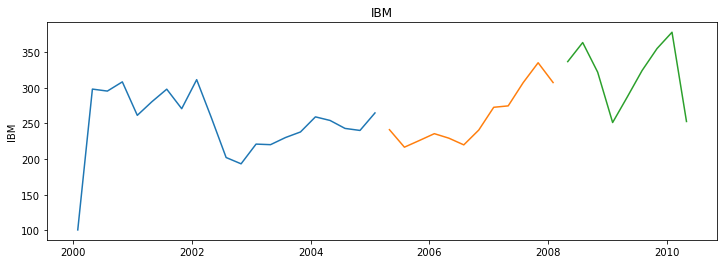

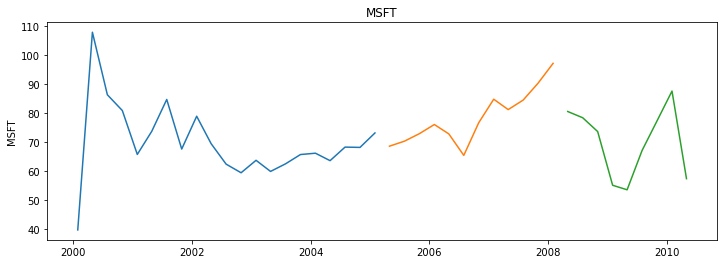

In [12]:
# Print out each modeling set to ensure the datapoints connect
# They will not connect in this case
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<br>

## 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [13]:
def make_predictions(modeling_set, method):
    y_hat = np.full_like(modeling_set, method)

    y_hat = pd.DataFrame(y_hat,
                         columns=modeling_set.columns,
                         index=modeling_set.index)
    return y_hat

In [14]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], y_hat[target_var])), 0)
    return rmse

In [15]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(y_hat[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [16]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Simple Average Time Series Model

In [17]:
simple_average = train.mean().round(2)
y_hat = make_predictions(validate, simple_average)

In [18]:
y_hat.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2005-04-30,41.49,90.45,47.29,249.94,69.98
2005-07-31,41.49,90.45,47.29,249.94,69.98
2005-10-31,41.49,90.45,47.29,249.94,69.98
2006-01-31,41.49,90.45,47.29,249.94,69.98
2006-04-30,41.49,90.45,47.29,249.94,69.98


AAPL -- RMSE: 253


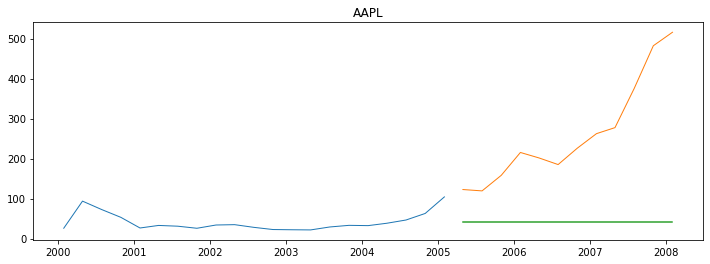

AMZN -- RMSE: 83


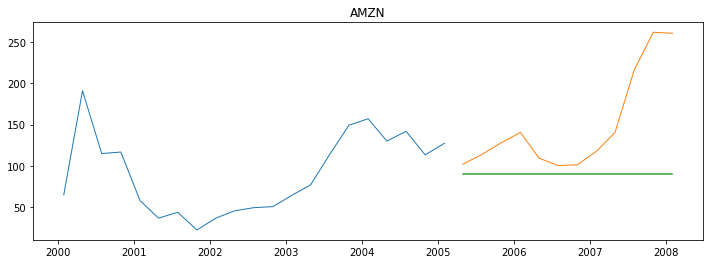

GOOG -- RMSE: 1286


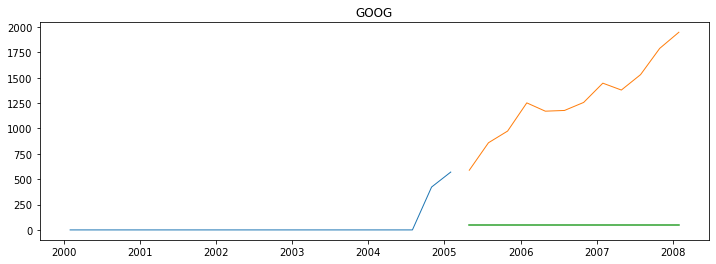

IBM -- RMSE: 39


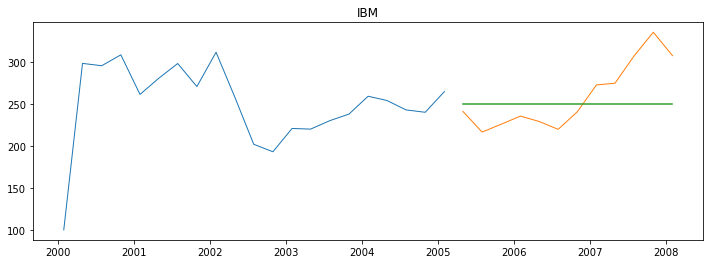

MSFT -- RMSE: 12


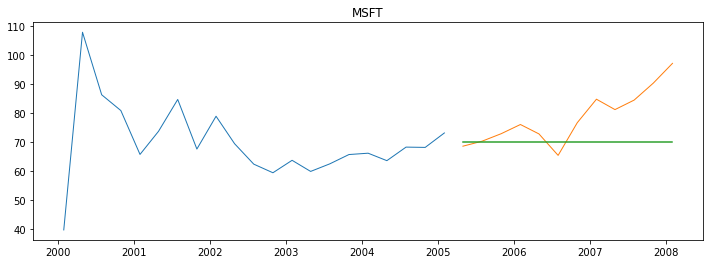

In [19]:
for ticker in train.columns:
    plot_and_eval(ticker)

In [20]:
for column in train.columns:
    eval_df = append_eval_df('simple_average', column)

In [21]:
eval_df

,model_type,target_var,rmse
0,simple_average,AAPL,253.0
1,simple_average,AMZN,83.0
2,simple_average,GOOG,1286.0
3,simple_average,IBM,39.0
4,simple_average,MSFT,12.0


### Moving Average

In [22]:
rolling_average = train.rolling(4).mean().iloc[-1].round(2)

In [23]:
y_hat = make_predictions(validate, rolling_average)

AAPL -- RMSE: 235


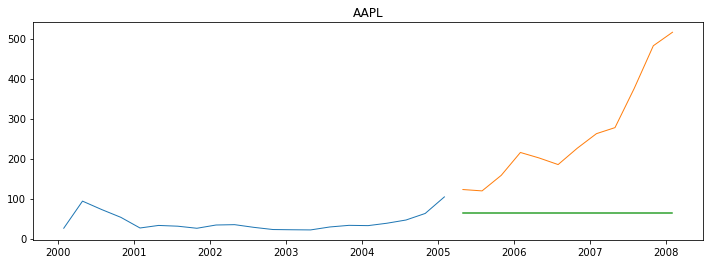

AMZN -- RMSE: 62


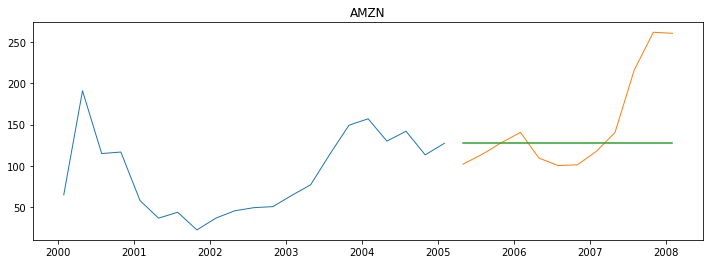

GOOG -- RMSE: 1095


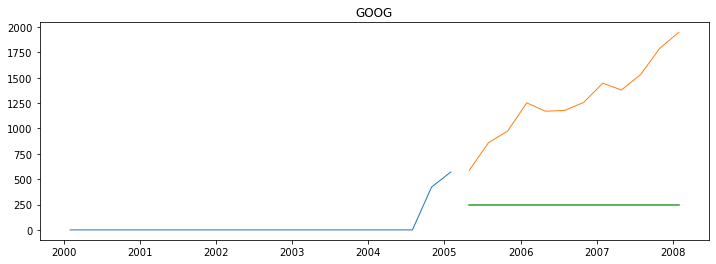

IBM -- RMSE: 39


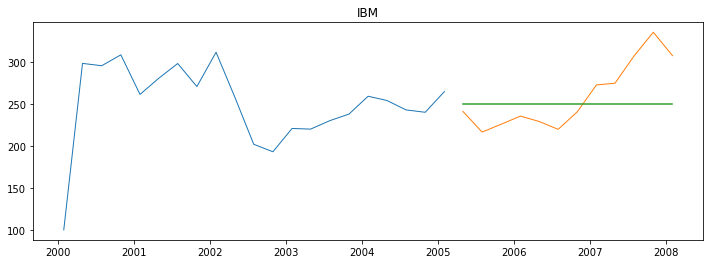

MSFT -- RMSE: 14


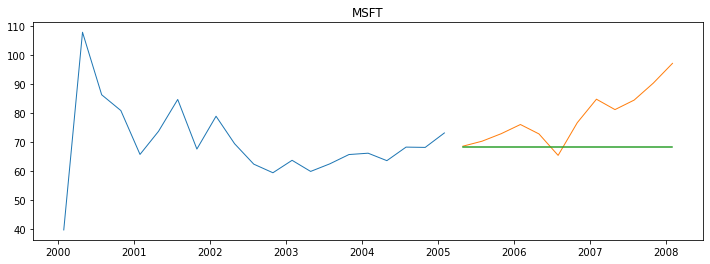

In [24]:
for column in train.columns:
    plot_and_eval(column)

In [25]:
for column in train.columns:
    eval_df = append_eval_df('moving_average', column)
eval_df

,model_type,target_var,rmse
0,simple_average,AAPL,253.0
1,simple_average,AMZN,83.0
2,simple_average,GOOG,1286.0
3,simple_average,IBM,39.0
4,simple_average,MSFT,12.0
5,moving_average,AAPL,235.0
6,moving_average,AMZN,62.0
7,moving_average,GOOG,1095.0
8,moving_average,IBM,39.0
9,moving_average,MSFT,14.0


In [26]:
periods = np.arange(5, 11)

for p in periods:
    p_rolling_average = train.rolling(p).mean().iloc[-1].round(2)
    y_hat = make_predictions(validate, p_rolling_average)
    model_type = str(p) + 'm moving average'
    for column in train.columns:
        eval_df = append_eval_df(model_type, column)
eval_df

,model_type,target_var,rmse
0,simple_average,AAPL,253.0
1,simple_average,AMZN,83.0
2,simple_average,GOOG,1286.0
3,simple_average,IBM,39.0
4,simple_average,MSFT,12.0
5,moving_average,AAPL,235.0
6,moving_average,AMZN,62.0
7,moving_average,GOOG,1095.0
8,moving_average,IBM,39.0
9,moving_average,MSFT,14.0


In [27]:
eval_df.pivot_table('rmse', 'model_type', 'target_var')

target_var,AAPL,AMZN,GOOG,IBM,MSFT
model_type,,,,,
10m moving average,254.0,69.0,1236.0,44.0,16.0
5m moving average,240.0,61.0,1142.0,39.0,14.0
6m moving average,244.0,60.0,1173.0,39.0,14.0
7m moving average,247.0,61.0,1196.0,40.0,15.0
8m moving average,250.0,63.0,1213.0,41.0,15.0
9m moving average,252.0,66.0,1226.0,42.0,16.0
moving_average,235.0,62.0,1095.0,39.0,14.0
simple_average,253.0,83.0,1286.0,39.0,12.0


### Holt's Linear Trend Model

AAPL 



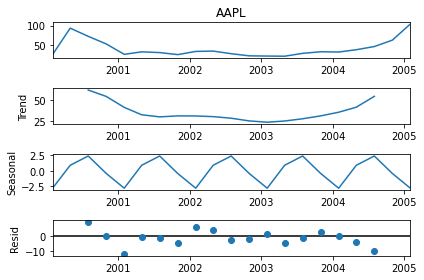

AMZN 



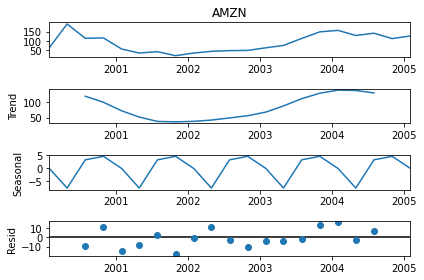

GOOG 



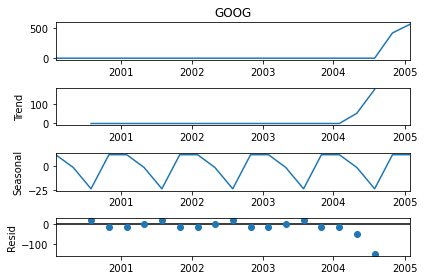

IBM 



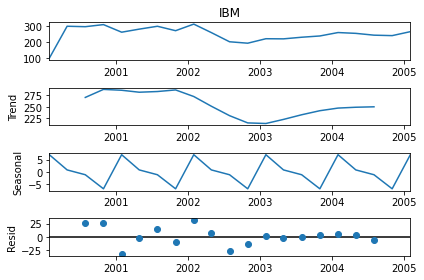

MSFT 



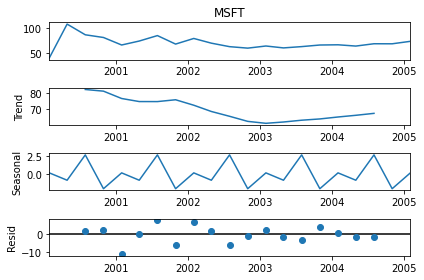

In [28]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [29]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    y_hat[col] = round(yhat_items, 2)

In [30]:
y_hat

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2005-04-30,283.68,552.13,108.34,983.70,315.06
2005-07-31,290.09,564.99,117.81,1004.69,321.36
2005-10-31,296.51,577.86,127.27,1025.67,327.66
2006-01-31,302.92,590.72,136.74,1046.66,333.96
2006-04-30,309.34,603.59,146.20,1067.65,340.26
2006-07-31,315.75,616.45,155.67,1088.64,346.57
2006-10-31,322.17,629.31,165.13,1109.62,352.87
2007-01-31,328.58,642.18,174.60,1130.61,359.17
2007-04-30,334.99,655.04,184.06,1151.60,365.47


AAPL -- RMSE: 120


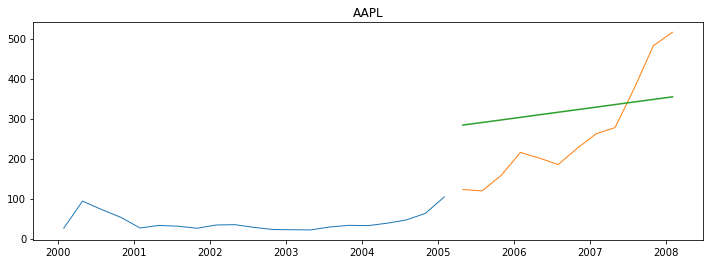

AMZN -- RMSE: 475


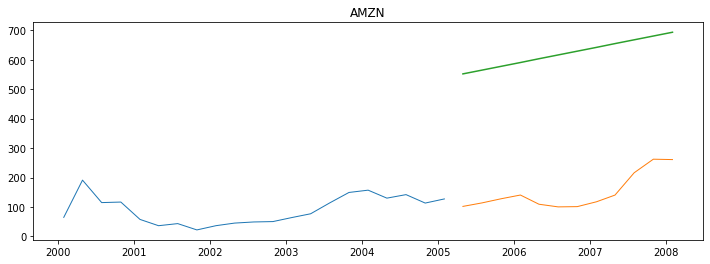

GOOG -- RMSE: 1169


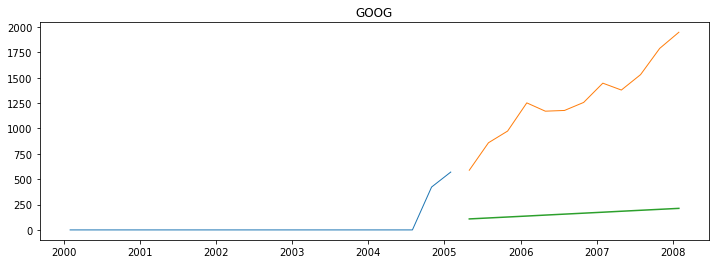

IBM -- RMSE: 841


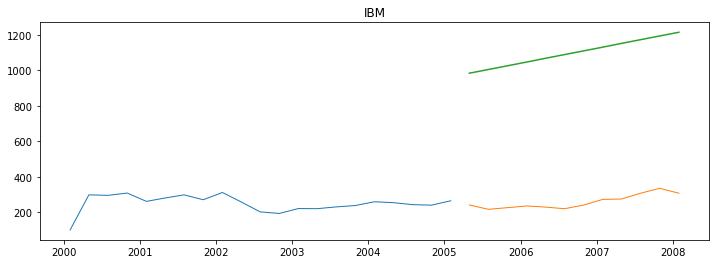

MSFT -- RMSE: 272


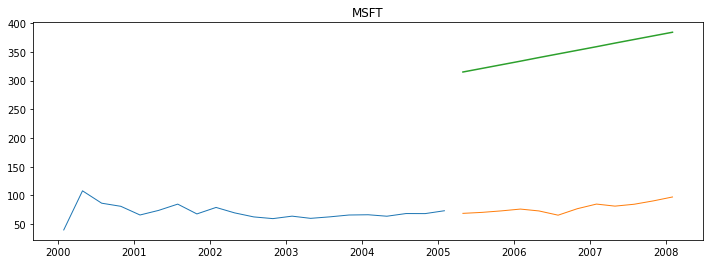

In [31]:
for col in train.columns:
    plot_and_eval(col)

In [34]:
for column in train.columns:
        eval_df = append_eval_df('Holts', column)

eval_df.pivot_table('rmse', 'model_type', 'target_var')

target_var,AAPL,AMZN,GOOG,IBM,MSFT
model_type,,,,,
10m moving average,254.0,69.0,1236.0,44.0,16.0
5m moving average,240.0,61.0,1142.0,39.0,14.0
6m moving average,244.0,60.0,1173.0,39.0,14.0
7m moving average,247.0,61.0,1196.0,40.0,15.0
8m moving average,250.0,63.0,1213.0,41.0,15.0
9m moving average,252.0,66.0,1226.0,42.0,16.0
Holts,120.0,475.0,1169.0,841.0,272.0
moving_average,235.0,62.0,1095.0,39.0,14.0
simple_average,253.0,83.0,1286.0,39.0,12.0


### Previous Time Period

# Optional: Using store item demand

## 1. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.

## 2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
Plot the 2018 monthly sales predictions.